In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
cwd = os.getcwd()

NOTEBOOK_DIR = os.path.dirname(cwd)
ROOT = os.path.dirname(os.path.dirname(os.path.dirname(NOTEBOOK_DIR)))

FIGURES_DIR = os.path.join(ROOT, 'figures/abc_parameterizations/debug_ipllr_renorm')
CONFIG_PATH = os.path.join(ROOT, 'pytorch/configs/abc_parameterizations', 'fc_ipllr_mnist.yaml')

In [3]:
import sys
sys.path.append(ROOT)

In [4]:
import os
from copy import deepcopy
import torch
import math
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, Subset, DataLoader
import torch.nn.functional as F

from utils.tools import read_yaml, set_random_seeds
from pytorch.configs.base import BaseConfig
from pytorch.configs.model import ModelConfig
from pytorch.models.abc_params.fully_connected.ipllr import FcIPLLR
from pytorch.models.abc_params.fully_connected.muP import FCmuP
from pytorch.models.abc_params.fully_connected.ntk import FCNTK
from pytorch.models.abc_params.fully_connected.standard_fc_ip import StandardFCIP
from utils.data.mnist import load_data
from utils.abc_params.debug_ipllr import *
from utils.plot.abc_parameterizations.debug_ipllr import *

### Load basic configuration and define variables 

In [5]:
N_TRIALS = 5
SEED = 30
L = 6
width = 1024
n_warmup_steps = 1
batch_size = 128
base_lr = 0.1
n_steps = 50

set_random_seeds(SEED)  # set random seed for reproducibility
config_dict = read_yaml(CONFIG_PATH)

In [6]:
config_dict = read_yaml(CONFIG_PATH)

input_size = config_dict['architecture']['input_size']

config_dict['architecture']['width'] = width
config_dict['architecture']['n_layers'] = L + 1
config_dict['optimizer']['params']['lr'] = base_lr
config_dict['scheduler'] = {'name': 'warmup_switch',
                            'params': {'n_warmup_steps': n_warmup_steps,
                                       'calibrate_base_lr': True,
                                       'default_calibration': False}}
        
base_model_config = ModelConfig(config_dict)

### Load data & define models

In [7]:
training_dataset, test_dataset = load_data(download=False, flatten=True)
train_data_loader = DataLoader(training_dataset, shuffle=True, batch_size=batch_size)
test_batches = list(DataLoader(test_dataset, shuffle=False, batch_size=batch_size))
batches = list(train_data_loader)
eval_batch = test_batches[0]

In [8]:
ipllrs = [FcIPLLR(base_model_config, n_warmup_steps=12, lr_calibration_batches=batches) for _ in range(N_TRIALS)]
base_model_config.scheduler = None
muPs = [FCmuP(base_model_config) for _ in range(N_TRIALS)]

initial base lr : [51.552181243896484, 26.091691970825195, 43.85205078125, 43.30146789550781, 43.17287063598633, 41.76435089111328, 97.51105499267578]
initial base lr : [51.39537048339844, 26.66145896911621, 46.33627700805664, 44.36362075805664, 44.04011154174805, 44.88881301879883, 113.00306701660156]
initial base lr : [49.3272705078125, 28.064228057861328, 50.07605743408203, 49.70188522338867, 47.9000129699707, 43.22859573364258, 99.06780242919922]
initial base lr : [50.66897964477539, 26.771169662475586, 46.67892837524414, 47.91236114501953, 50.036041259765625, 47.292484283447266, 106.41696166992188]
initial base lr : [49.68304443359375, 25.56040382385254, 38.66799545288086, 38.99928283691406, 34.20057678222656, 33.298065185546875, 84.0416488647461]


In [9]:
for ipllr in ipllrs:
    ipllr.scheduler.calibrate_base_lr(ipllr, batches=batches)

initial base lr : [51.552181243896484, 26.091691970825195, 43.85205078125, 43.30146789550781, 43.17287063598633, 41.76435089111328, 97.51105499267578]
initial base lr : [51.39537048339844, 26.66145896911621, 46.33627700805664, 44.36362075805664, 44.04011154174805, 44.88881301879883, 113.00306701660156]
initial base lr : [49.3272705078125, 28.064228057861328, 50.07605743408203, 49.70188522338867, 47.9000129699707, 43.22859573364258, 99.06780242919922]
initial base lr : [50.66897964477539, 26.771169662475586, 46.67892837524414, 47.91236114501953, 50.036041259765625, 47.292484283447266, 106.41696166992188]
initial base lr : [49.68304443359375, 25.56040382385254, 38.66799545288086, 38.99928283691406, 34.20057678222656, 33.298065185546875, 84.0416488647461]


In [10]:
for i, ipllr in enumerate(ipllrs):
    ipllr.copy_initial_params_from_model(muPs[i])
    ipllr.initialize_params()

In [11]:
muPs_0 = [deepcopy(muP) for muP in muPs]

x, y = batches[0]
for muP in muPs:
    train_model_one_step(ipllr, x, y, batch_size)

input abs mean in training:  0.7020161151885986
loss derivatives for model: tensor([[-0.9000,  0.1000,  0.1000,  ...,  0.1000,  0.1000,  0.1000],
        [ 0.1000, -0.9000,  0.1000,  ...,  0.1000,  0.1000,  0.1000],
        [ 0.1000,  0.1000,  0.1000,  ...,  0.1000,  0.1000, -0.9000],
        ...,
        [ 0.1000,  0.1000,  0.1000,  ...,  0.1000, -0.9000,  0.1000],
        [ 0.1000,  0.1000,  0.1000,  ...,  0.1000, -0.9000,  0.1000],
        [ 0.1000, -0.9000,  0.1000,  ...,  0.1000,  0.1000,  0.1000]])
average training loss for model1 : 2.3025827407836914

input abs mean in training:  0.7020161151885986
loss derivatives for model: tensor([[-0.9420,  0.0681,  0.0909,  ...,  0.0675,  0.3895,  0.0738],
        [ 0.0485, -0.9413,  0.0828,  ...,  0.0581,  0.4682,  0.0646],
        [ 0.0595,  0.0695,  0.0920,  ...,  0.0689,  0.3781, -0.9249],
        ...,
        [ 0.0328,  0.0419,  0.0653,  ...,  0.0414, -0.3905,  0.0474],
        [ 0.0644,  0.0741,  0.0953,  ...,  0.0735, -0.6602,  0.079

In [12]:
x, y = batches[0]
ipllrs_1 = []
for ipllr in ipllrs:
    train_model_one_step(ipllr, x, y, batch_size)
    ipllrs_1.append(deepcopy(ipllr))

input abs mean in training:  0.7020161151885986
loss derivatives for model: tensor([[-0.9000,  0.1000,  0.1000,  ...,  0.1000,  0.1000,  0.1000],
        [ 0.1000, -0.9000,  0.1000,  ...,  0.1000,  0.1000,  0.1000],
        [ 0.1000,  0.1000,  0.1000,  ...,  0.1000,  0.1000, -0.9000],
        ...,
        [ 0.1000,  0.1000,  0.1000,  ...,  0.1000, -0.9000,  0.1000],
        [ 0.1000,  0.1000,  0.1000,  ...,  0.1000, -0.9000,  0.1000],
        [ 0.1000, -0.9000,  0.1000,  ...,  0.1000,  0.1000,  0.1000]])
average training loss for model1 : 2.3025827407836914

input abs mean in training:  0.7020161151885986
loss derivatives for model: tensor([[-0.9000,  0.1000,  0.1000,  ...,  0.1000,  0.1000,  0.1000],
        [ 0.1000, -0.9000,  0.1000,  ...,  0.1000,  0.1000,  0.1000],
        [ 0.1000,  0.1000,  0.1000,  ...,  0.1000,  0.1000, -0.9000],
        ...,
        [ 0.1000,  0.1000,  0.1000,  ...,  0.1000, -0.9000,  0.1000],
        [ 0.1000,  0.1000,  0.1000,  ...,  0.1000, -0.9000,  0.100

In [13]:
results = {'muP': [], 'IPLLR': []}
results['muP'] = [collect_scales(muPs[i], muPs_0[i], batches[1:], eval_batch, n_steps) 
                  for i in range(N_TRIALS)]

In [14]:
results['IPLLR'] = [collect_scales(ipllrs[i], ipllrs_1[i], batches[1:], eval_batch, n_steps) 
                    for i in range(N_TRIALS)]

# Training

In [15]:
mode = 'training'

In [16]:
losses_muP = [r[0] for r in results['muP']]
losses_ip = [r[0] for r in results['IPLLR']]

chis_muP = [r[1] for r in results['muP']]
chis_ip = [r[1] for r in results['IPLLR']]

## Losses and derivatives

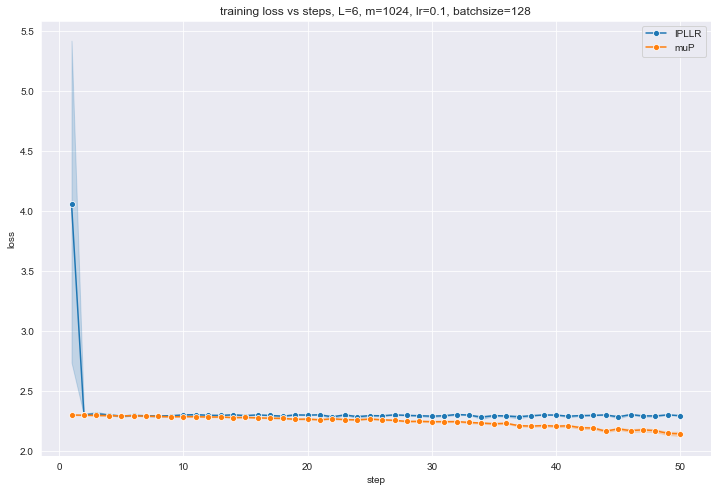

In [17]:
key = 'loss'
plt.figure(figsize=(12, 8))
plot_losses(losses_ip, losses_muP, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, mode=mode)
plt.savefig(os.path.join(FIGURES_DIR, '{}_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, L, width, base_lr, 
                                                                               batch_size)))
plt.show()

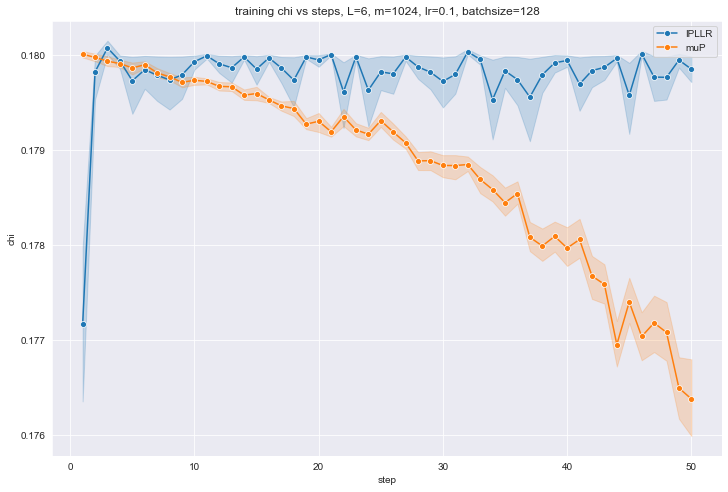

In [18]:
key = 'chi'
plt.figure(figsize=(12, 8))
plot_losses(chis_ip, chis_muP, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, mode=mode)
plt.savefig(os.path.join(FIGURES_DIR, '{}_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, L, width, base_lr, 
                                                                               batch_size)))
plt.show()

### Magnitude of the actvations of the network at different layers

In [19]:
dfs_muP = [r[2] for r in results['muP']]
dfs_ip = [r[2] for r in results['IPLLR']]

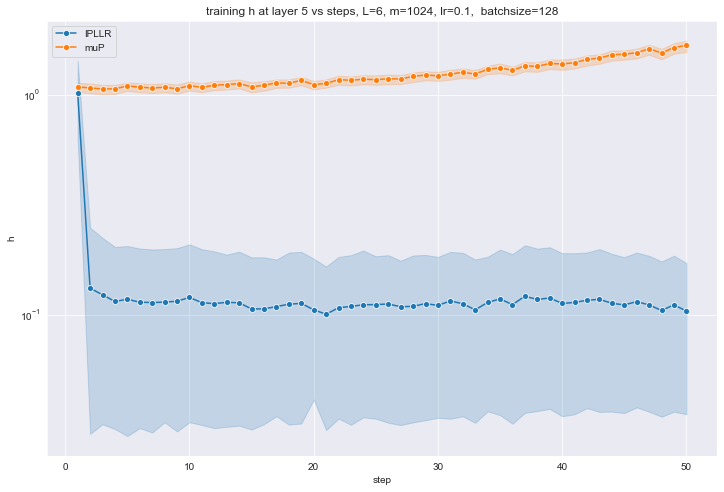

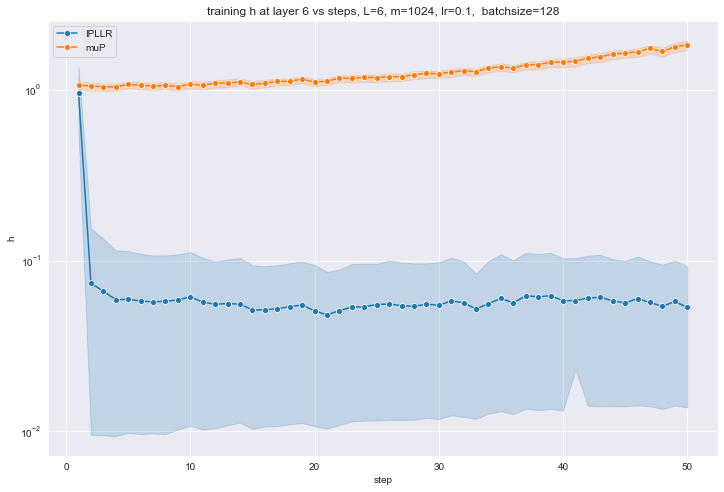

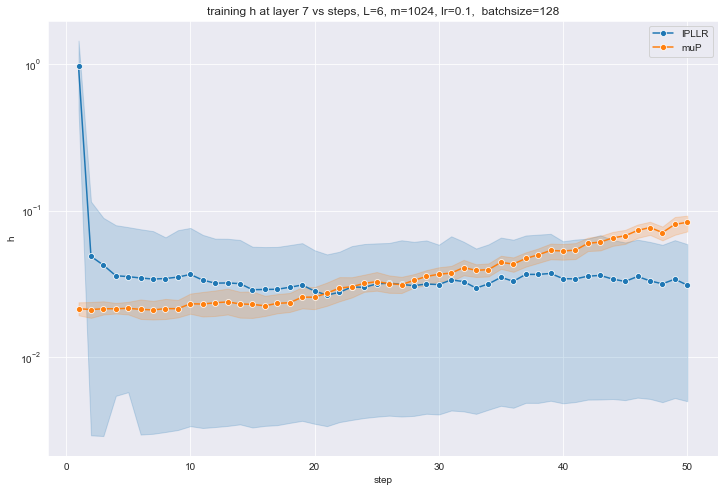

In [20]:
key = 'h'
for l in range(L-1, L+2):
    plt.figure(figsize=(12, 8))
    plot_output_scale(dfs_ip, dfs_muP, layer=l, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, 
                      mode=mode, y_scale='log')
    plt.savefig(os.path.join(FIGURES_DIR, 
                             '{}_{}_layer_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, l, L, width, base_lr, 
                                                                               batch_size)))
    plt.show()

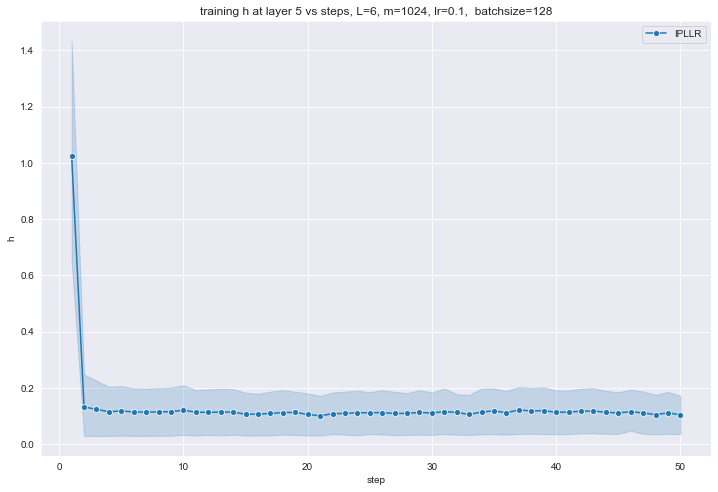

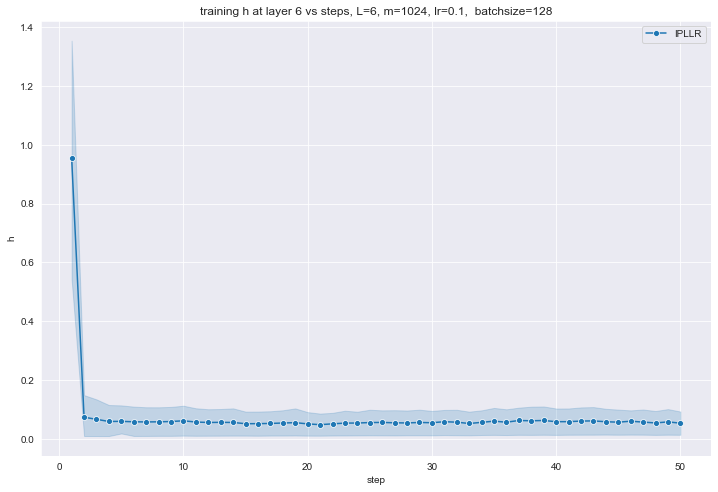

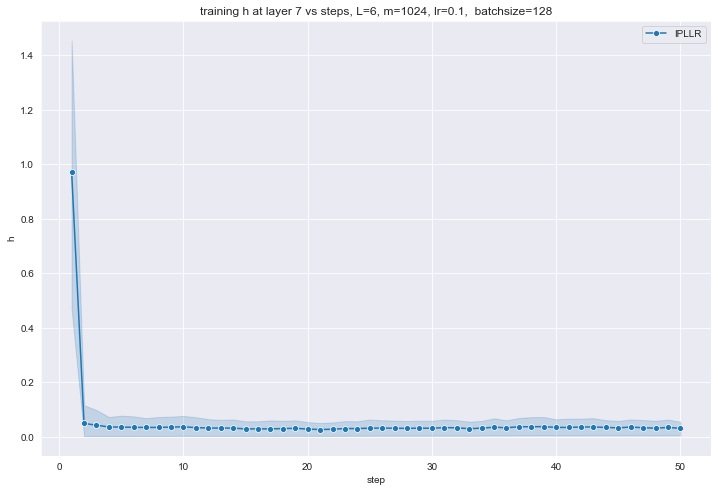

In [21]:
key = 'h'
for l in range(L-1, L+2):
    plt.figure(figsize=(12, 8))
    plot_output_scale(dfs_ip, None, layer=l, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, 
                      mode=mode, y_scale='log')
    plt.savefig(os.path.join(FIGURES_DIR, 
                             '{}_{}_ip_layer_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, l, L, width, base_lr, 
                                                                                  batch_size)))
    plt.show()

### Contribution of the init to the activations at different layers.

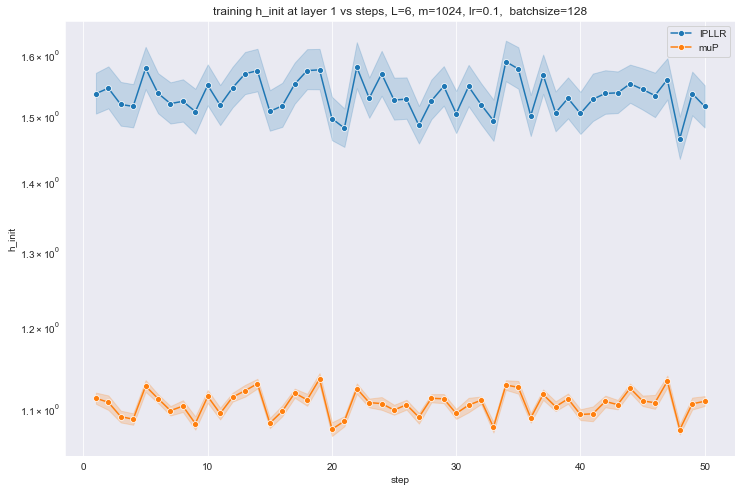

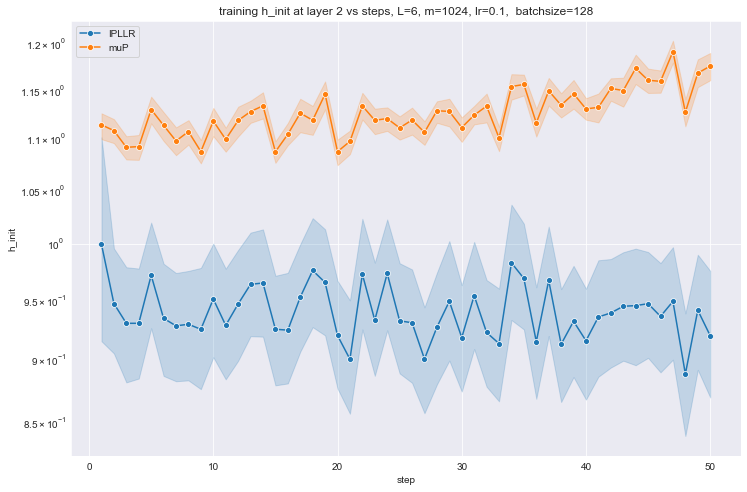

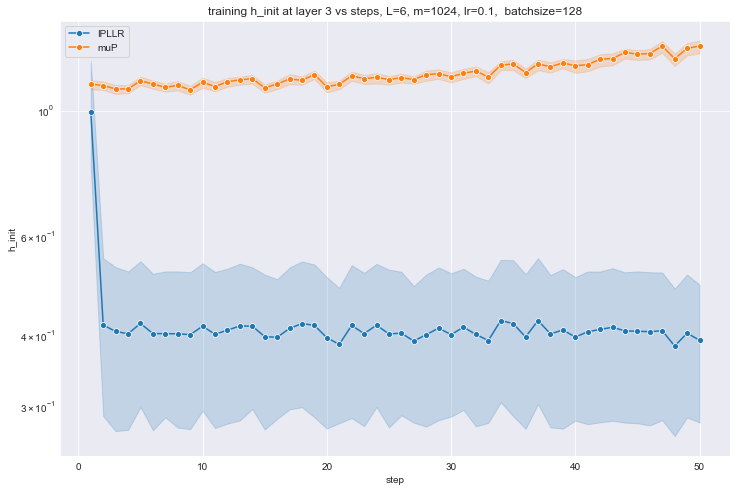

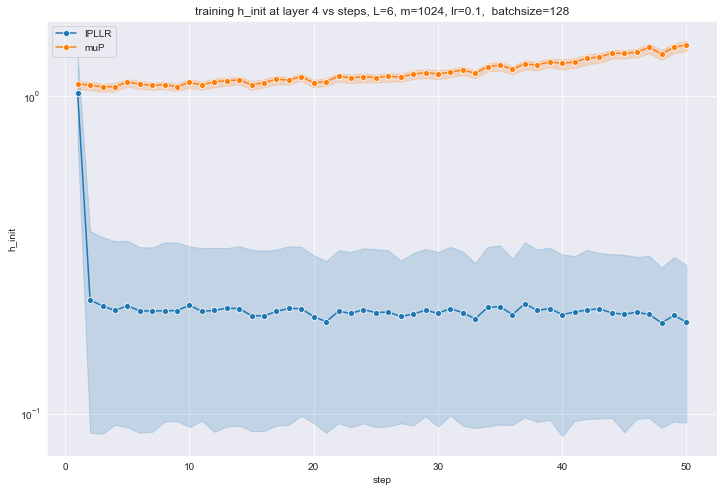

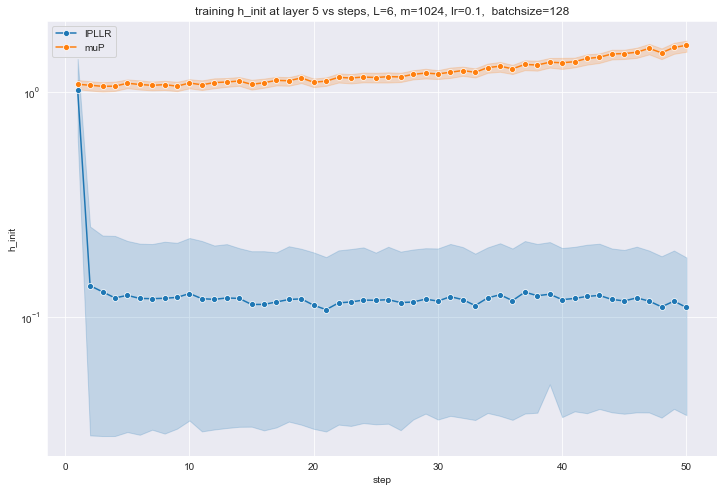

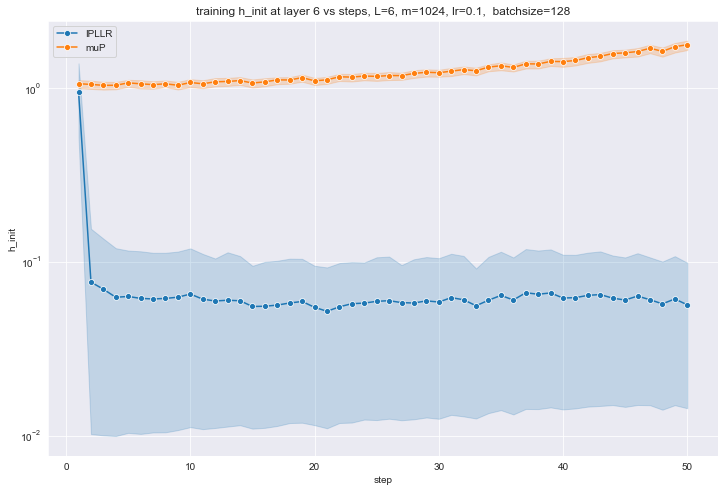

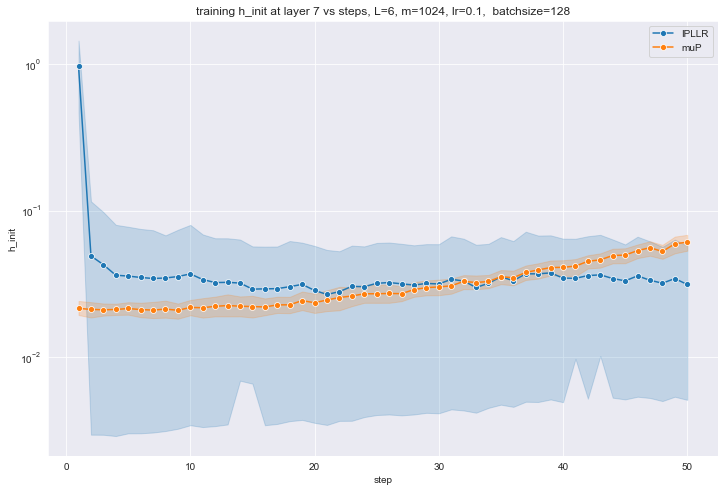

In [22]:
key = 'h_init'
for l in range(1, L+2):
    plt.figure(figsize=(12, 8))
    plot_output_scale(dfs_ip, dfs_muP, layer=l, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size,
                      mode=mode, y_scale='log')
    plt.savefig(os.path.join(FIGURES_DIR, 
                             '{}_{}_layer_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, l, L, width, base_lr,
                                                                               batch_size)))
    plt.show()

### Magnitude of the update at different layers.

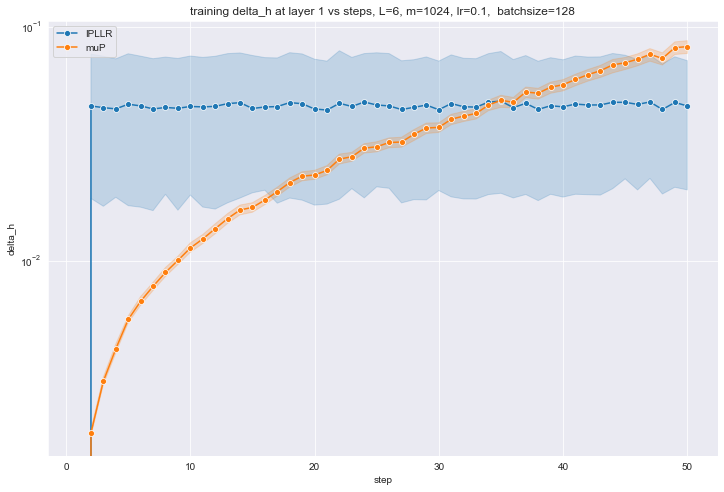

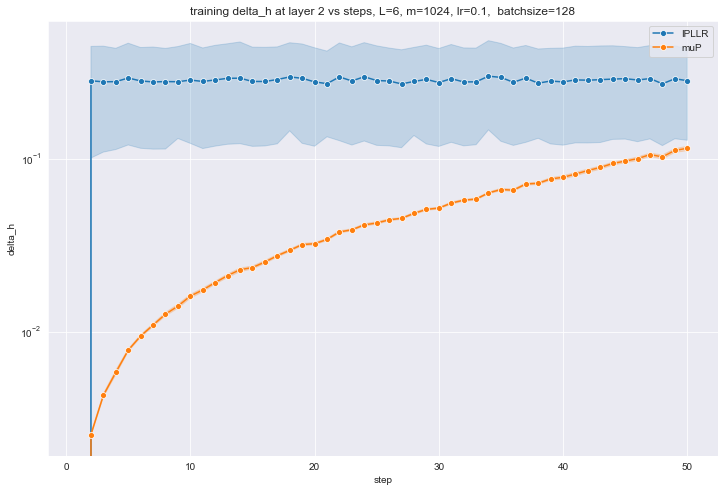

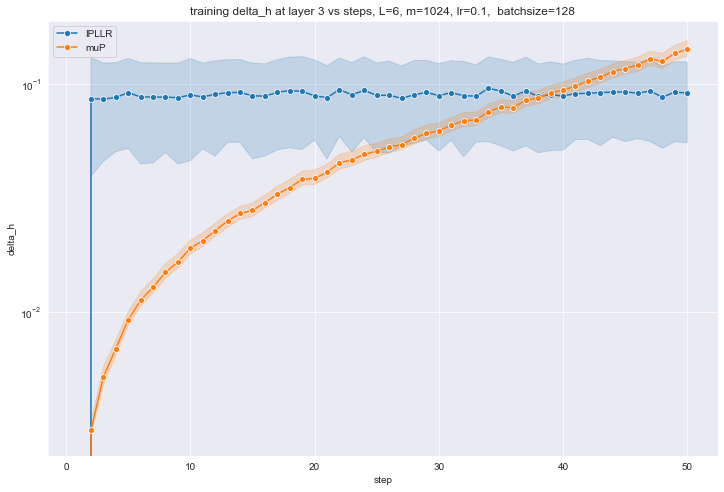

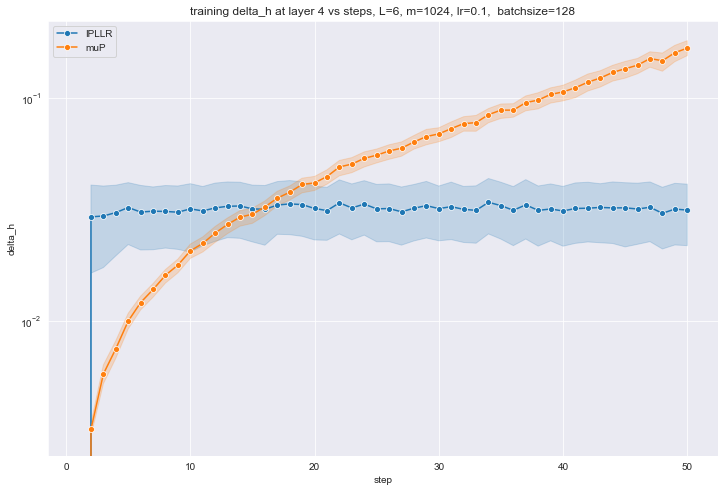

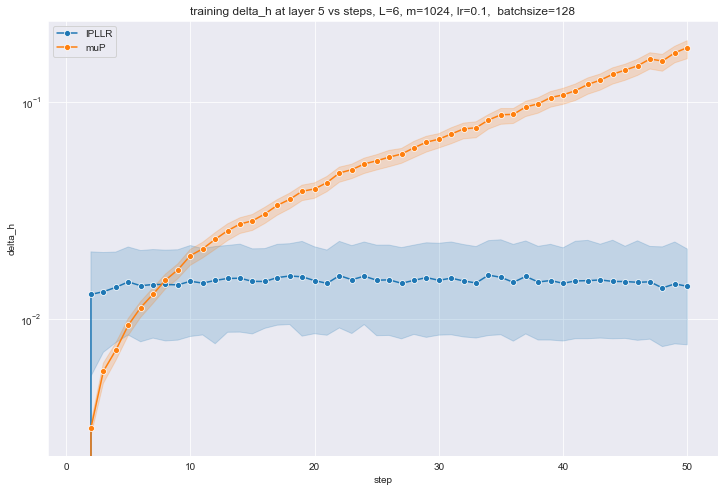

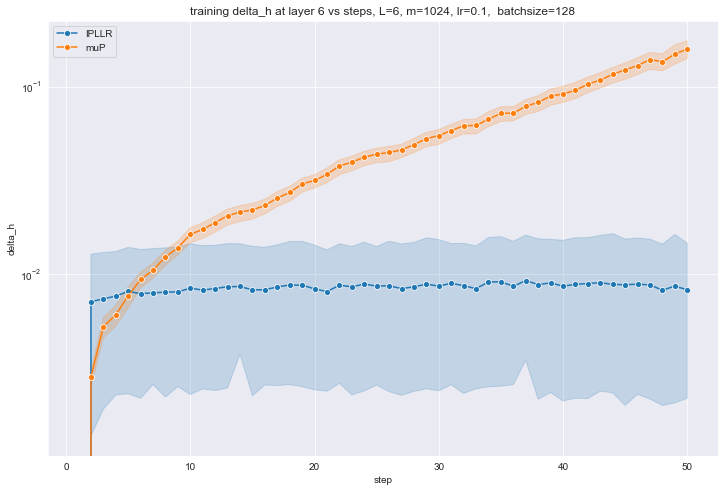

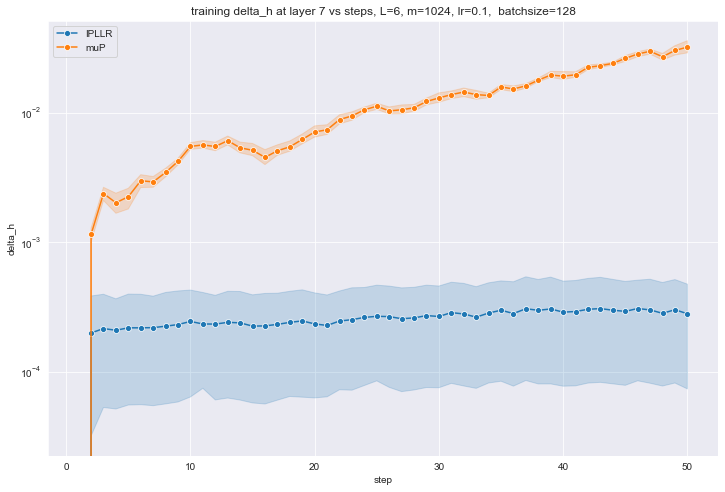

In [23]:
key = 'delta_h'
for l in range(1, L+2):
    plt.figure(figsize=(12, 8))
    plot_output_scale(dfs_ip, dfs_muP, layer=l, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size,
                      mode=mode, y_scale='log')
    plt.savefig(os.path.join(FIGURES_DIR, 
                             '{}_{}_layer_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, l, L, width, base_lr,
                                                                               batch_size)))
    plt.show()

# Validation

In [24]:
mode = 'val'

In [25]:
dfs_muP = [r[3] for r in results['muP']]
dfs_ip = [r[3] for r in results['IPLLR']]

## Losses and derivatives

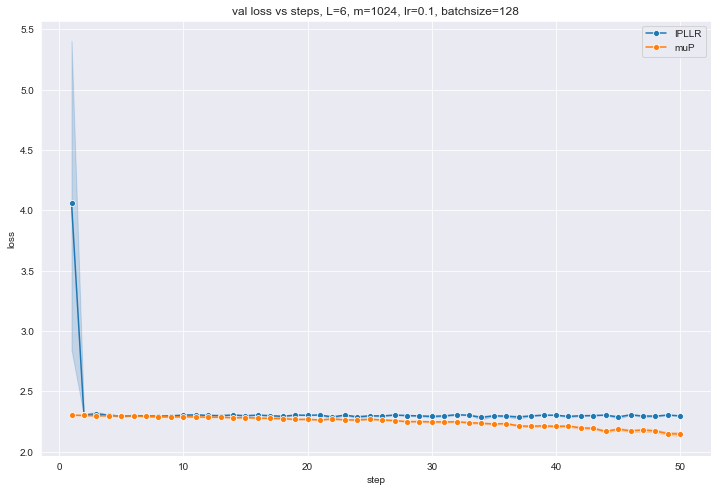

In [26]:
key = 'loss'
plt.figure(figsize=(12, 8))
plot_losses(losses_ip, losses_muP, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, mode=mode)
plt.savefig(os.path.join(FIGURES_DIR, '{}_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, L, width, base_lr, 
                                                                               batch_size)))
plt.show()

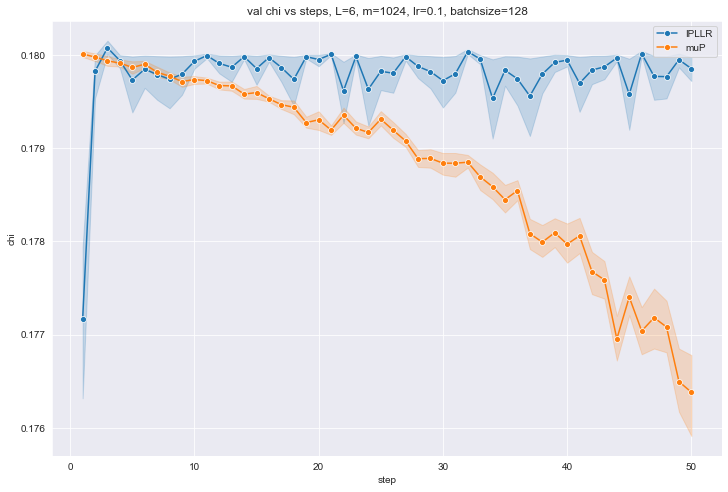

In [27]:
key = 'chi'
plt.figure(figsize=(12, 8))
plot_losses(chis_ip, chis_muP, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, mode=mode)
plt.savefig(os.path.join(FIGURES_DIR, '{}_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, L, width, base_lr, 
                                                                               batch_size)))
plt.show()

### Magnitude of the actvations of the network at different layers

In [28]:
dfs_muP = [r[2] for r in results['muP']]
dfs_ip = [r[2] for r in results['IPLLR']]

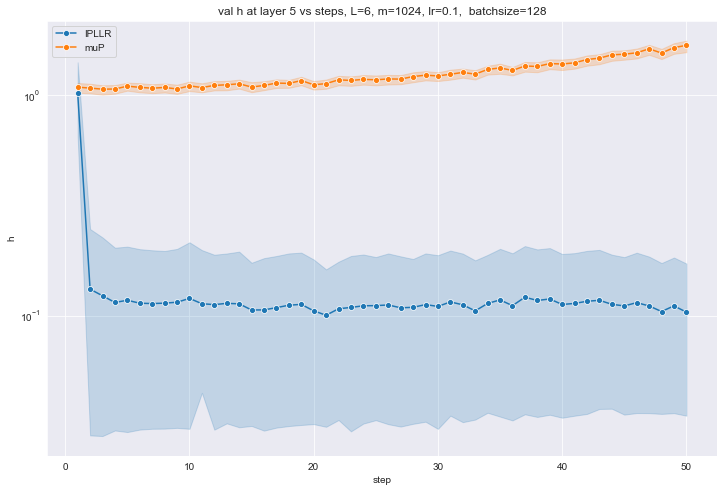

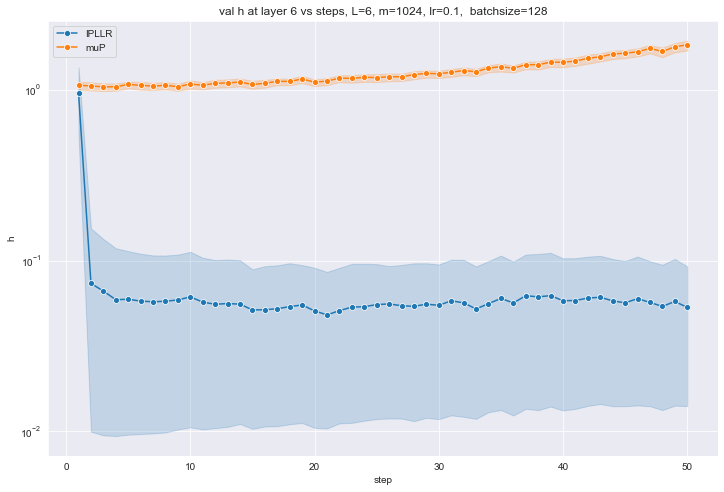

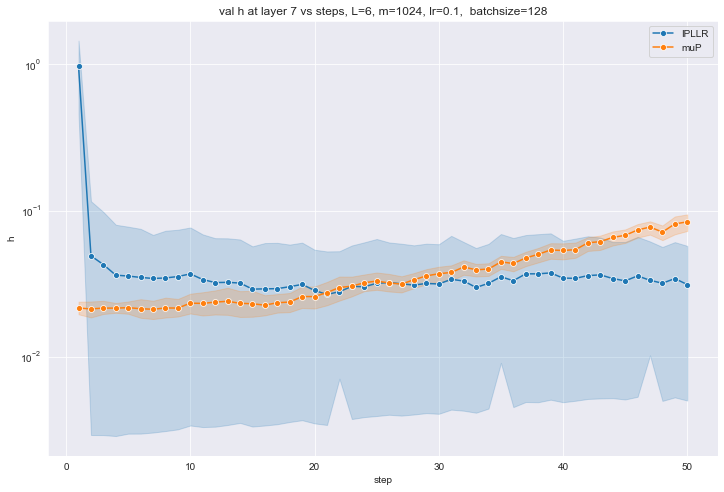

In [29]:
key = 'h'
for l in range(L-1, L+2):
    plt.figure(figsize=(12, 8))
    plot_output_scale(dfs_ip, dfs_muP, layer=l, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, 
                      mode=mode, y_scale='log')
    plt.savefig(os.path.join(FIGURES_DIR, 
                             '{}_{}_layer_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, l, L, width, base_lr, 
                                                                               batch_size)))
    plt.show()

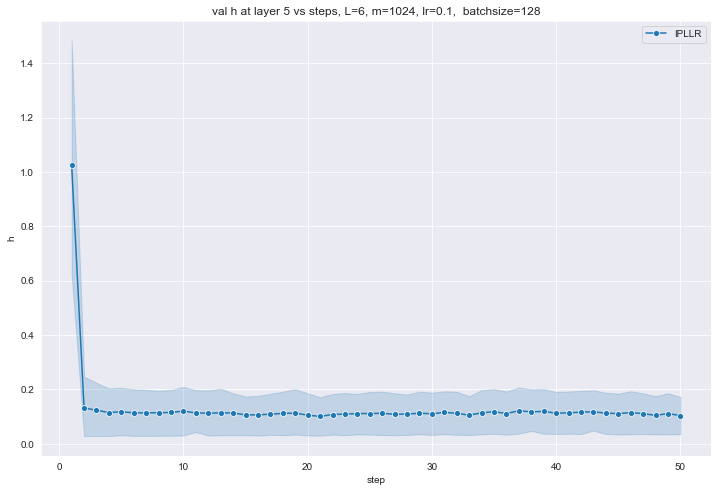

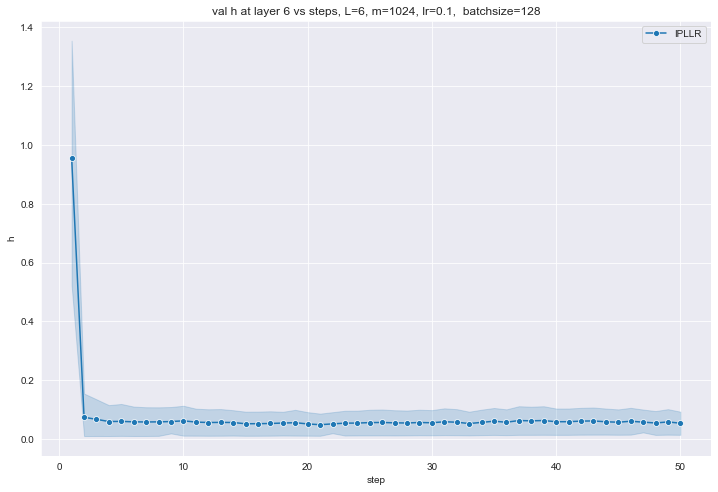

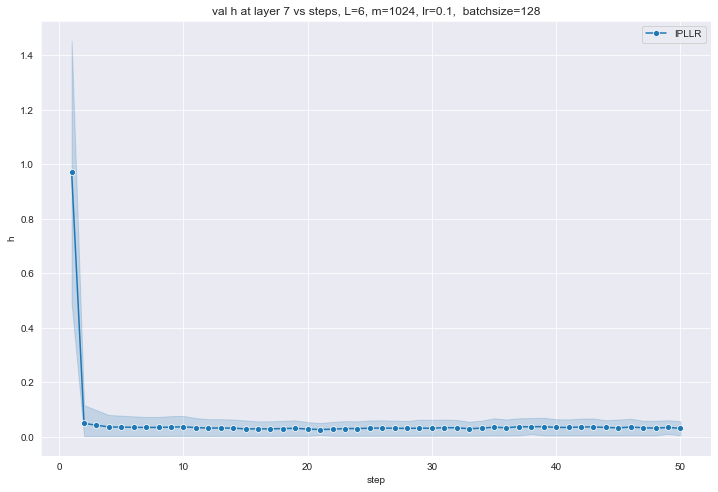

In [30]:
key = 'h'
for l in range(L-1, L+2):
    plt.figure(figsize=(12, 8))
    plot_output_scale(dfs_ip, None, layer=l, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, 
                      mode=mode, y_scale='log')
    plt.savefig(os.path.join(FIGURES_DIR, 
                             '{}_{}_ip_layer_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, l, L, width, base_lr, 
                                                                                  batch_size)))
    plt.show()

### Contribution of the init to the activations at different layers.

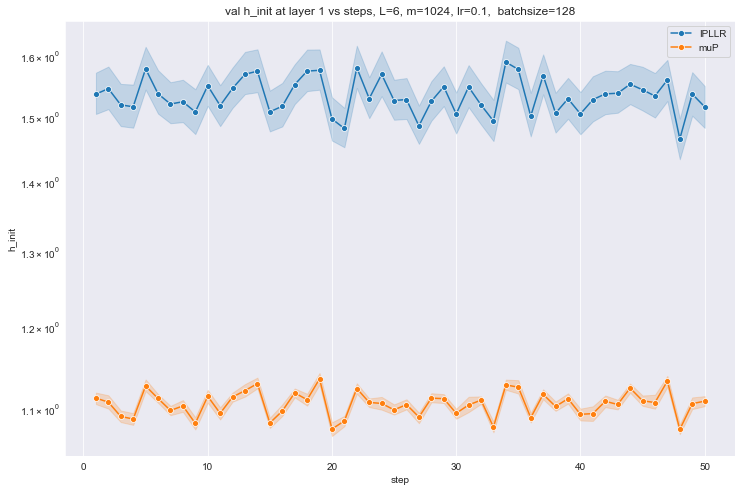

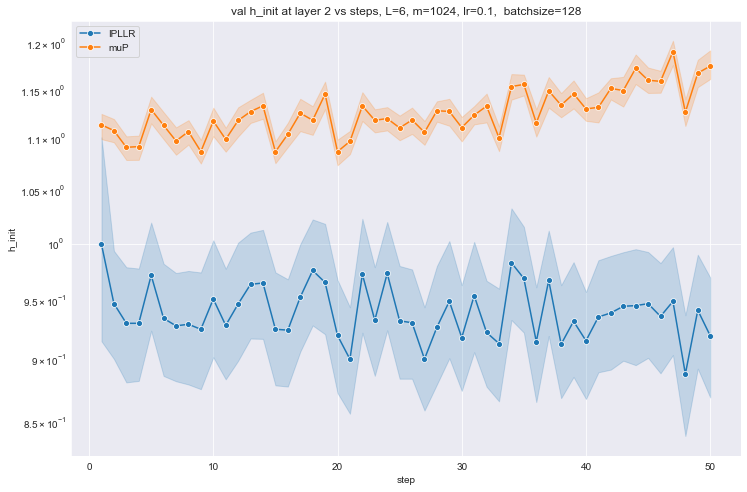

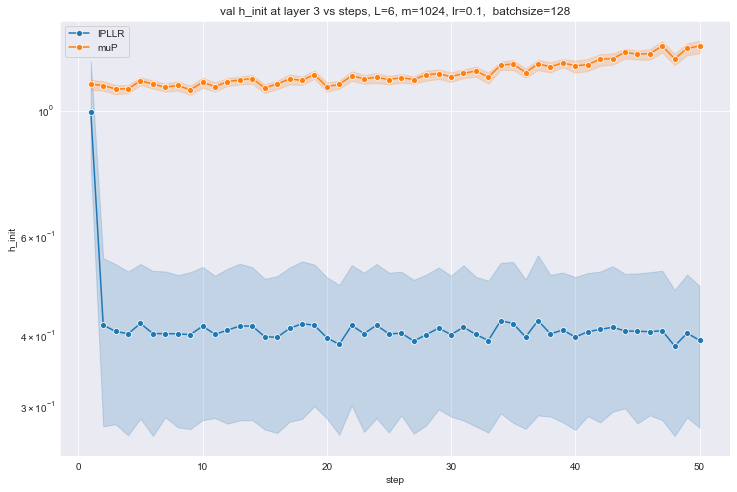

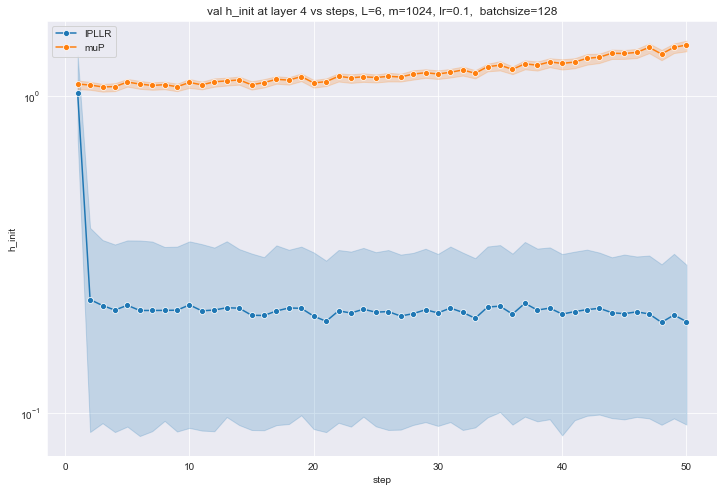

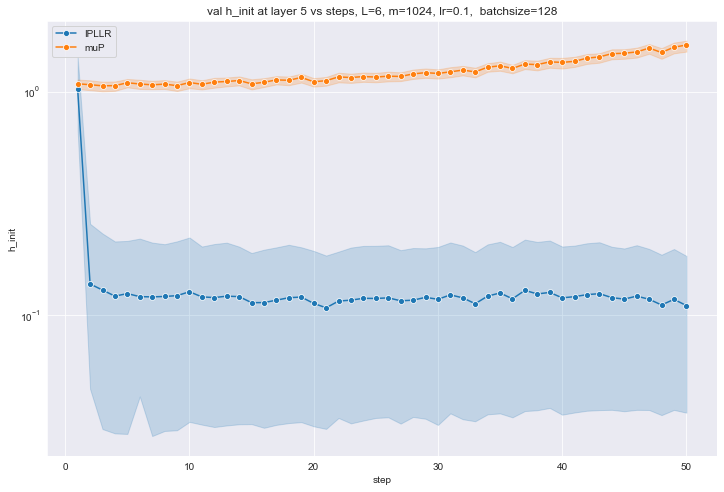

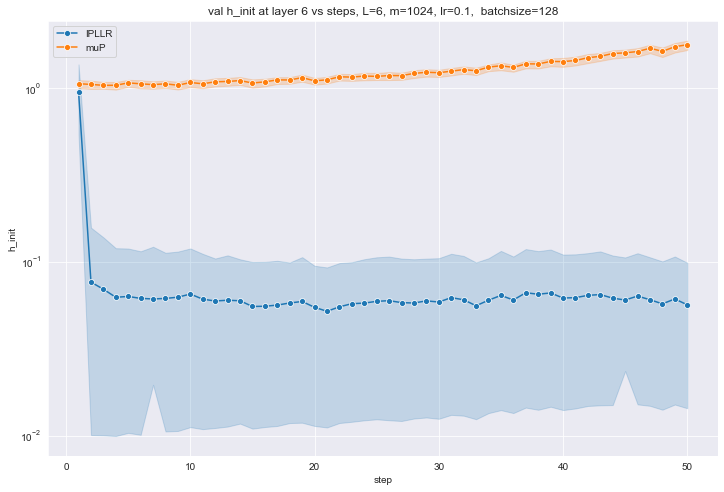

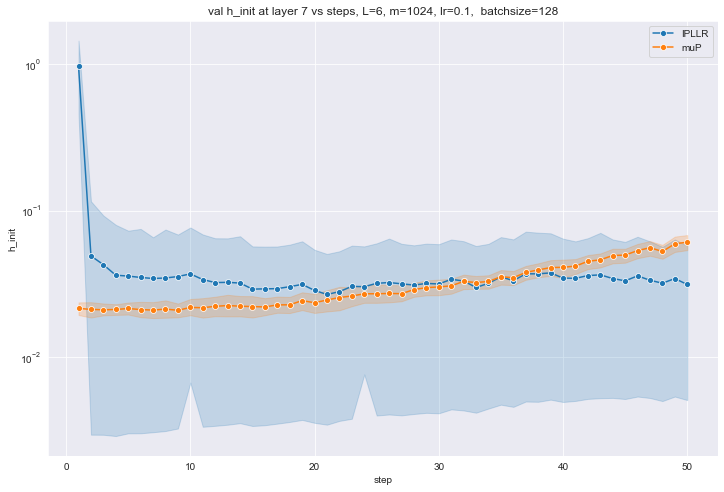

In [31]:
key = 'h_init'
for l in range(1, L+2):
    plt.figure(figsize=(12, 8))
    plot_output_scale(dfs_ip, dfs_muP, layer=l, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size,
                      mode=mode, y_scale='log')
    plt.savefig(os.path.join(FIGURES_DIR, 
                             '{}_{}_layer_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, l, L, width, base_lr,
                                                                               batch_size)))
    plt.show()

### Magnitude of the update at different layers.

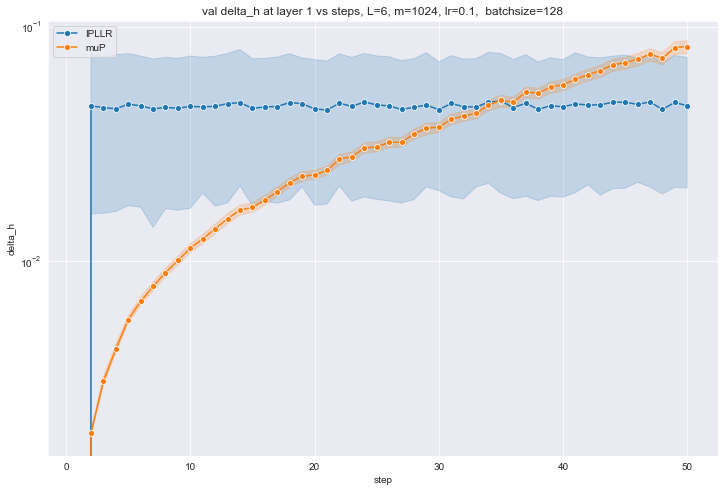

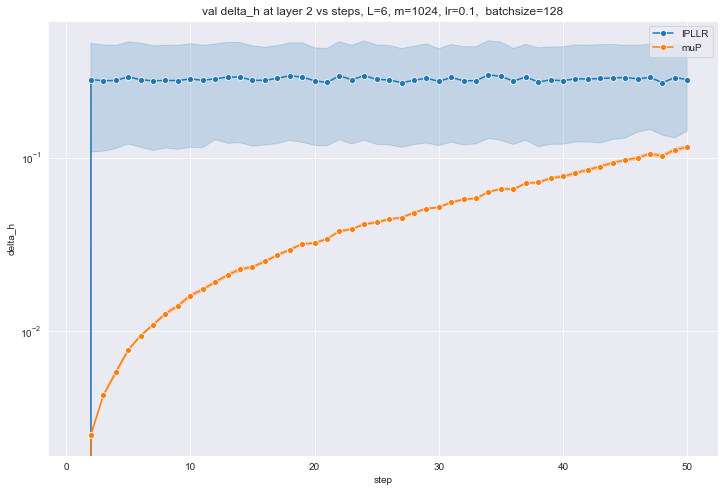

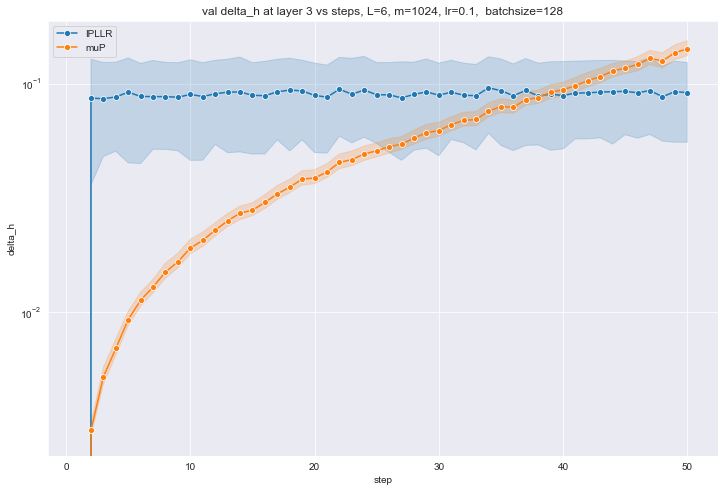

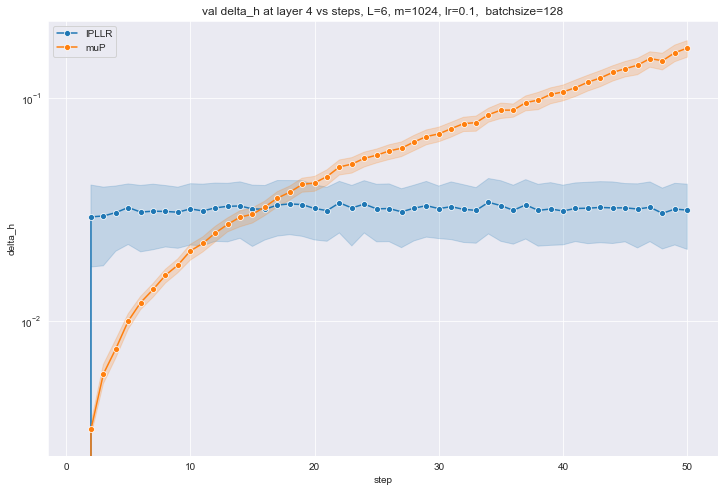

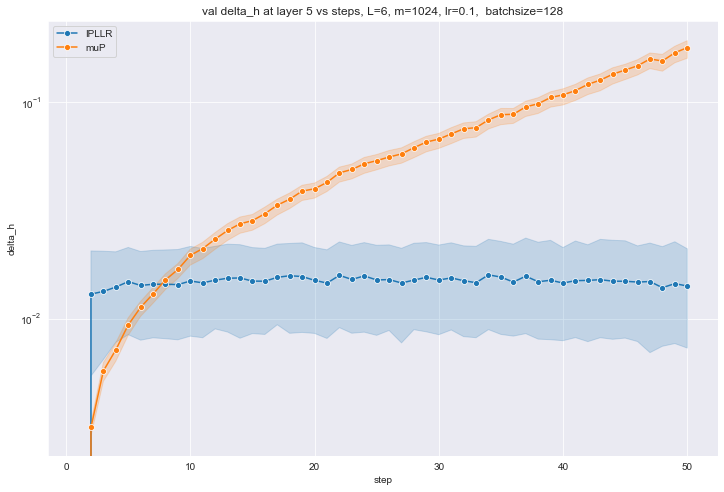

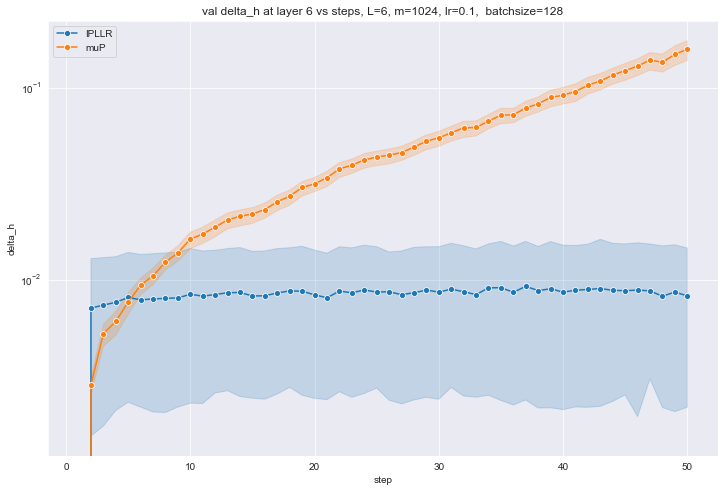

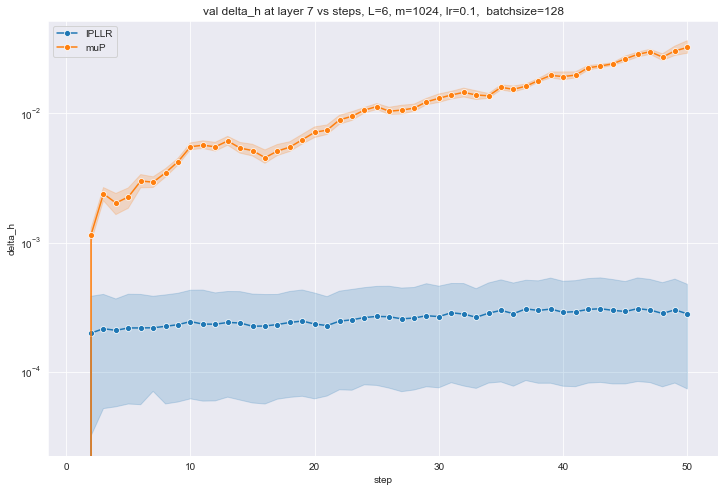

In [32]:
key = 'delta_h'
for l in range(1, L+2):
    plt.figure(figsize=(12, 8))
    plot_output_scale(dfs_ip, dfs_muP, layer=l, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size,
                      mode=mode, y_scale='log')
    plt.savefig(os.path.join(FIGURES_DIR, 
                             '{}_{}_layer_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, l, L, width, base_lr,
                                                                               batch_size)))
    plt.show()